In [45]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, auc,roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Load the dataset
df = pd.read_csv(r'C:\Users\Kailash\Downloads\customer_booking.csv', encoding='latin-1')

In [3]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [5]:
# Columns to impute
numeric_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
binary_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Fill numerical with median
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Fill binary with 0
df[binary_cols] = df[binary_cols].fillna(0)


In [7]:
# Add peak hour flag
df['is_peak_hour'] = df['flight_hour'].apply(lambda x: 1 if 7 <= x <= 10 or 16 <= x <= 19 else 0)


In [53]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [9]:
# Define features and target
X = df.drop(columns='booking_complete')
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
# Detect string-based columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
print("Categorical columns to encode:", categorical_cols.tolist())

# Apply one-hot encoding to both train and test
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns (in case test set is missing a category)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


Categorical columns to encode: ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']


In [15]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Grid Search with cross-validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Retrieve the best model
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [39]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [41]:
# Best model
best_model = grid_search.best_estimator_

# Retrieve the best model
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)


Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [47]:
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Predictions
y_pred = best_model.predict(X_test)

# Accuracy Score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc:.4f}")

# F1 Score (for binary classification)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Mean Squared Error (usually for regression, but can show classification confidence error)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")



Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      8504
           1       0.46      0.27      0.34      1496

    accuracy                           0.84     10000
   macro avg       0.67      0.61      0.63     10000
weighted avg       0.82      0.84      0.83     10000

ROC AUC Score: 0.7975316585840699
Accuracy Score: 0.8439
F1 Score: 0.3449
Mean Squared Error: 0.1561


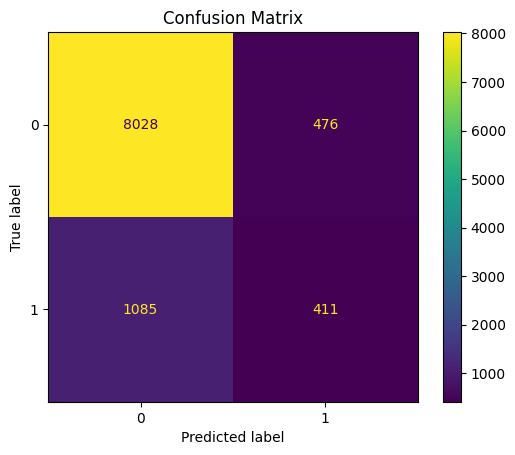

In [49]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()


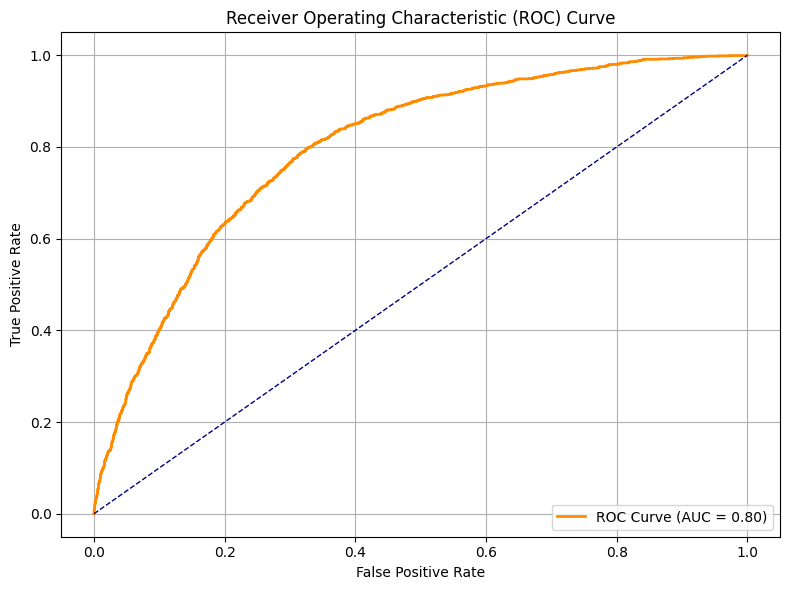

In [51]:
# Compute FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Kailash\AppData\Local\Temp\ipykernel_21788\3190445415.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp_df.head(15), x='Importance', y='Feature', palette='Blues_d')


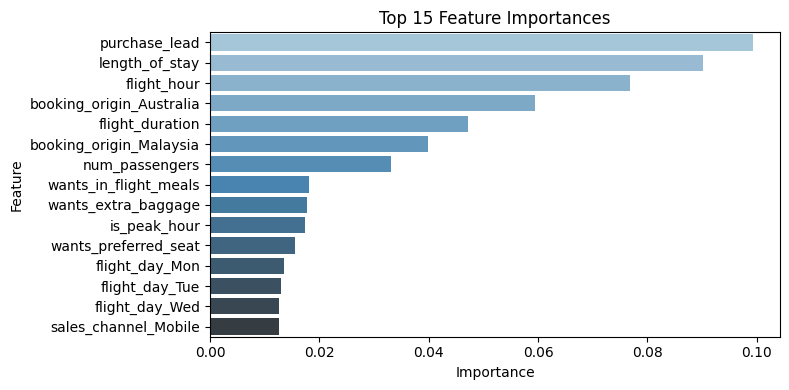

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame from feature importances
feature_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(8, 4))
sns.barplot(data=feature_imp_df.head(15), x='Importance', y='Feature', palette='Blues_d')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()
